<a href="https://colab.research.google.com/github/rashidmeras/EVA_PHASE1/blob/master/Assignment7/EVA_S7_Assignment_7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA Session7 Assignment 7B: 

Objective:

To build a network following the ENAS architecture as shwon in the figure for CIFAR10 dataset.

> ![Enas](https://rashidmeras.github.io/images/eva/EnasFigure7.png)


1. The dotted lines seen are the skip-connections that needs to be added in the network.
2.  Add BN and ReLU after every layer
3. Train for 100 Epochs


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Conv2D, Activation, Flatten, Dropout, Input, Lambda, Dense, Add, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU
from keras import layers


# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

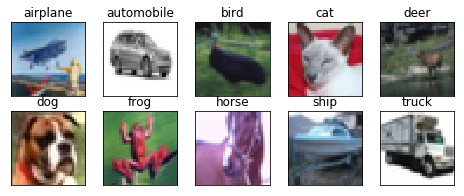

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Image Normalization

In [0]:

batch_size = 128

# standardize images
def prep_standardize(train, test):
	# convert from integers to floats
	train_stan = train.astype('float32')
	test_stan  = test.astype('float32')
	# calculate statistics
	m = train_stan.mean()
	s = train_stan.std()
	# center datasets
	train_stan = (train_stan - m) / s
	test_stan  = (test_stan - m) / s
	# return normalized images
	return train_stan, test_stan

train_features, test_features = prep_standardize(train_features, test_features)

# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (train_features.min(), train_features.max()))
print('Test min=%.3f, max=%.3f' % (test_features.min(), test_features.max()))

Train min=-1.882, max=2.093
Test min=-1.882, max=2.093


## Functional Network

In [0]:
# Function for common layer
def add_common_layers(y):
    y = BatchNormalization()(y)
    y = ReLU()(y)  
    y = Dropout(0.1)(y)
    
    return y

# Function for space to depth conversion 
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)  

# Define the network  
img_height = 32
img_width = 32
channel = 3
  
# INPUT  
input = Input(shape=(img_height, img_width, channel))

# =========================================: Layer-1 :============================================= #
x = SeparableConv2D(32, (5,5), padding='same', use_bias=False, name='L1_Dep_Sep_Conv')(input)
x = add_common_layers(x)
# =========================================: Layer-1 :============================================= #

skip_L1 = x

# =========================================: Layer-2 :============================================= #
x = Conv2D(32, (5,5), padding='same', use_bias=False, name='L2_Norm_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-2 :============================================= #

skip_L2 = x

# =========================================: Layer-3 :============================================= #
x = Conv2D(32, (5,5), padding='same', use_bias=False, name='L3_Norm_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-3 :============================================= #

skip_L3 = x

# conc L3 with L1
x = concatenate([x, skip_L1])

# =========================================: Layer-4 :============================================= #
x = SeparableConv2D(10, (5,5), padding='same', use_bias=False, name='L4_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-4 :============================================= #

skip_L4 = x

# conc L4 with L1
x = concatenate([x, skip_L1])

# Max-Pooling layer
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

# =========================================: Layer-5 :============================================= #
x = SeparableConv2D(32, (3,3), padding='same', use_bias=False, name='L5_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-5 :============================================= #

skip_L5 = x

# space2depth L1, L4
s2d_L1 = Lambda(space_to_depth_x2)(skip_L1)
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)

# conc L5 with L1, L4
x = concatenate([x, s2d_L1, s2d_L4])

# =========================================: Layer-6 :============================================= #
x = Conv2D(32, (5,5), padding='same', use_bias=False, name='L6_Norm_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-6 :============================================= #

skip_L6 = x

# space2depth L3
s2d_L3 = Lambda(space_to_depth_x2)(skip_L3)

# conc L6 with L3, L5
x = concatenate([x, s2d_L3, skip_L5])

# =========================================: Layer-7 :============================================= #
x = SeparableConv2D(10, (3,3), padding='same', use_bias=False, name='L7_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-7 :============================================= #

skip_L7 = x

# space2depth L1, L3, L4
s2d_L1 = Lambda(space_to_depth_x2)(skip_L1)
s2d_L3 = Lambda(space_to_depth_x2)(skip_L3)
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)

# conc L7 with L1, L3, L4, L5, L6
x = concatenate([x, s2d_L1, s2d_L3, s2d_L4, skip_L5, skip_L6])

# =========================================: Layer-8 :============================================= #
x = SeparableConv2D(32, (5,5), padding='same', use_bias=False, name='L8_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-8 :============================================= #

skip_L8 = x

# space2depth L1, L4
s2d_L1 = Lambda(space_to_depth_x2)(skip_L1)
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)

# conc L8 with L1, L4, L5, L7
x = concatenate([x, s2d_L1, s2d_L4, skip_L5, skip_L7])

# Max-Pooling layer
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

s2d_L6 = Lambda(space_to_depth_x2)(skip_L6)

# conc MP2 with L6
x = concatenate([x, s2d_L6])

# =========================================: Layer-9 :============================================= #
x = Conv2D(32, (5,5), padding='same', use_bias=False, name='L9_Norm_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-9 :============================================= #

skip_L9 = x

# space2depth L1, L2, L4, L7
s2d_L1 = Lambda(space_to_depth_x2)(skip_L1)
s2d_L2 = Lambda(space_to_depth_x2)(skip_L2)
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)
s2d_L7 = Lambda(space_to_depth_x2)(skip_L7)
s2d_L1 = Lambda(space_to_depth_x2)(s2d_L1)
s2d_L2 = Lambda(space_to_depth_x2)(s2d_L2)
s2d_L4 = Lambda(space_to_depth_x2)(s2d_L4)

# conc L9 with L1, L2, L4, L7
x = concatenate([x, s2d_L1, s2d_L2, s2d_L4, s2d_L7])

# =========================================: Layer-10 :============================================ #
x = SeparableConv2D(10, (5,5), padding='same', use_bias=False, name='L10_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-10 :============================================ #

skip_L10 = x

# space2depth L2, L3, L5
s2d_L2 = Lambda(space_to_depth_x2)(skip_L2)
s2d_L2 = Lambda(space_to_depth_x2)(s2d_L2)
s2d_L3 = Lambda(space_to_depth_x2)(skip_L3)
s2d_L3 = Lambda(space_to_depth_x2)(s2d_L3)
s2d_L5 = Lambda(space_to_depth_x2)(skip_L5)

# conc L10 with L2, L3, L5, L9
x = concatenate([x, s2d_L2, s2d_L3, s2d_L5, skip_L9])

# =========================================: Layer-11 :============================================ #
x = Conv2D(32, (3,3), padding='same', use_bias=False, name='L11_Norm_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-11 :============================================ #

skip_L11 = x

# space2depth L3, L4, L5, L7
s2d_L3 = Lambda(space_to_depth_x2)(skip_L3)
s2d_L3 = Lambda(space_to_depth_x2)(s2d_L3)
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)
s2d_L4 = Lambda(space_to_depth_x2)(s2d_L4)
s2d_L5 = Lambda(space_to_depth_x2)(skip_L5)
s2d_L7 = Lambda(space_to_depth_x2)(skip_L7)

# conc L11 with L3, L4, L5, L7, L10
x = concatenate([x, s2d_L3, s2d_L4, s2d_L5, s2d_L7, skip_L10])

# =========================================: Layer-12 :============================================ #
x = SeparableConv2D(10, (5,5), padding='same', use_bias=False, name='L12_Dep_Sep_Conv')(x)
x = add_common_layers(x)
# =========================================: Layer-12 :============================================ #

# space2depth L4, L7
s2d_L4 = Lambda(space_to_depth_x2)(skip_L4)
s2d_L4 = Lambda(space_to_depth_x2)(s2d_L4)
s2d_L7 = Lambda(space_to_depth_x2)(skip_L7)

# conc L12 with L4, L7, L10
x = concatenate([x, s2d_L4, s2d_L7, skip_L10])

# =========================================: Layer-x :============================================ #
x = Conv2D(10, (1,1), padding='same', use_bias=False, name='Lx_Norm_Conv')(x)
# =========================================: Layer-x :============================================ #

# ======================================: GAP & Softmax :========================================= #
flat_layer = GlobalAveragePooling2D()(x)
output = Activation('softmax')(flat_layer)
# ======================================: GAP & Softmax :========================================= #

# OUTPUT
model = Model(inputs=[input], outputs=[output])
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='ENAS_CIFAR10_7B_Network.png')

W0614 15:01:36.368094 140683255547776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 15:01:36.383363 140683255547776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 15:01:36.386688 140683255547776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0614 15:01:36.417071 140683255547776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0614 15:01:36.417958 1406832555

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L1_Dep_Sep_Conv (SeparableConv2 (None, 32, 32, 32)   171         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         L1_Dep_Sep_Conv[0][0]            
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

##Visualizing the network architecture:

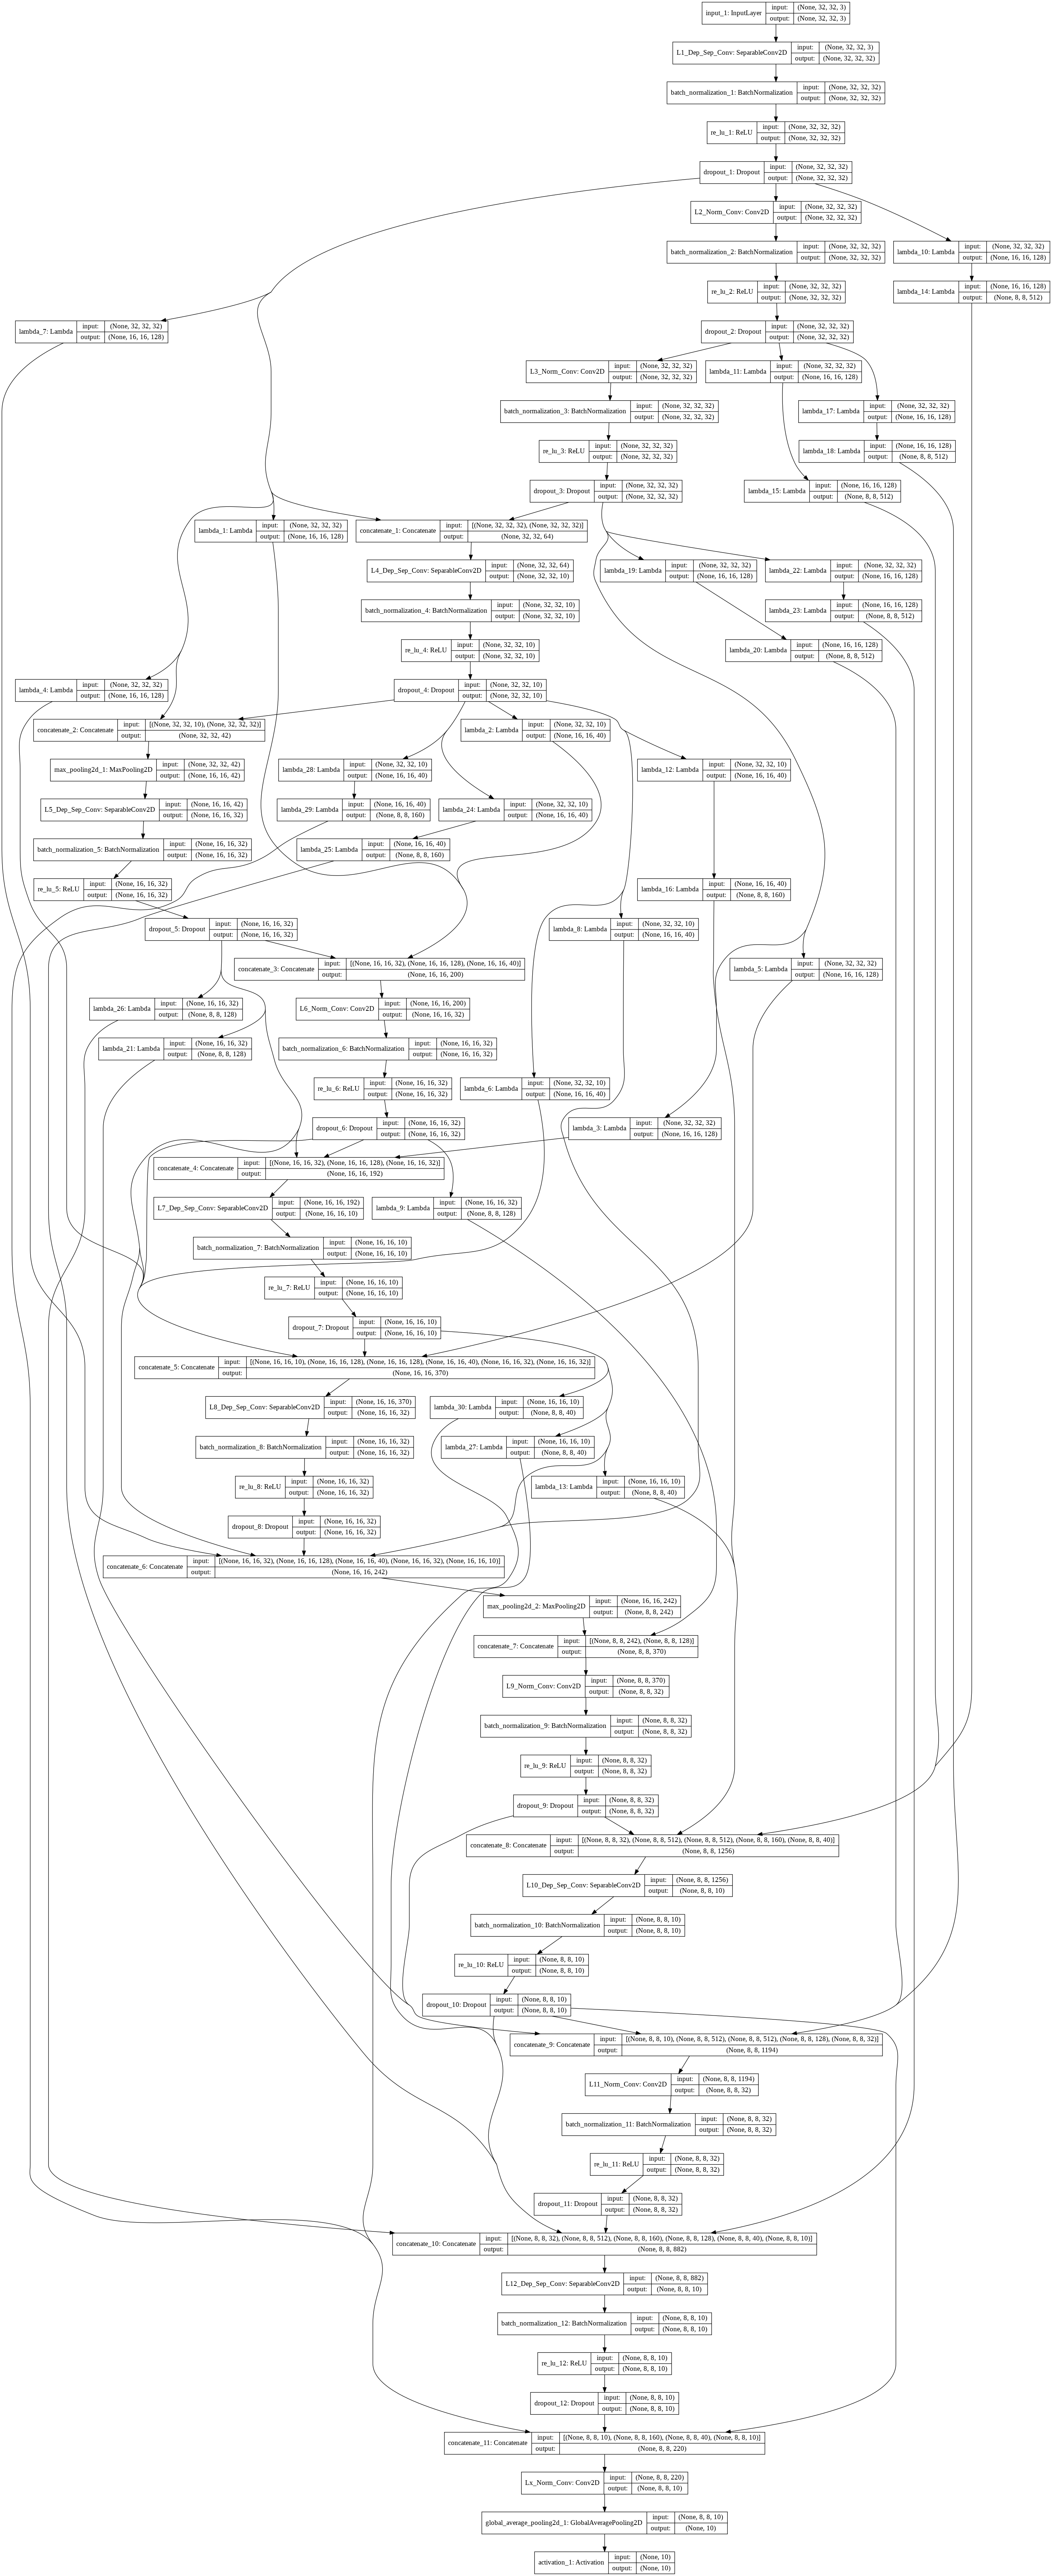

In [0]:
from IPython.display import Image
Image(retina=True, filename='ENAS_CIFAR10_7B_Network.png')

W0614 15:01:40.316430 140683255547776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0614 15:01:40.329063 140683255547776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 38s 753us/step - loss: 0.2443 - acc: 0.9080 - val_loss: 0.2712 - val_acc: 0.8967

Epoch 00001: val_acc improved from -inf to 0.89675, saving model to best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 34s 671us/step - loss: 0.1896 - acc: 0.9257 - val_loss: 0.2097 - val_acc: 0.9233

Epoch 00002: val_acc improved from 0.89675 to 0.92335, saving model to best_model.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 34s 680us/step - loss: 0.1640 - acc: 0.9357 - val_loss: 0.1915 - val_acc: 0.9262

Epoch 00003: val_acc improved from 0.92335 to 0.92623, saving model to best_model.h5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.

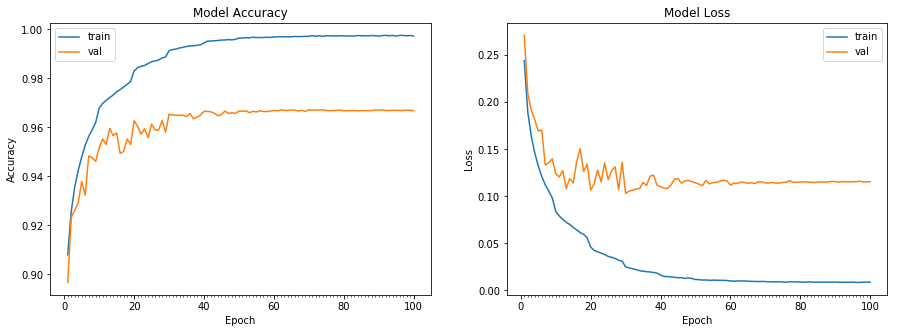

Accuracy on test data is: 82.90


In [0]:
import math
import numpy as np
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# Define custom loss
def custom_loss(actual,predicted):
    sqr_w = 0
    lamda = 1e-2
    
    for layer in model.layers:
       sqr_w = sqr_w + np.sum(np.sum(np.sum(np.square(layer.get_weights()))))
        
    l2_regularization = (lamda*sqr_w)/2*(batch_size)    
    loss = K.binary_crossentropy(actual,predicted) + l2_regularization
    # Return a function
    return loss

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
model.compile(optimizer= sgd,
#               loss = custom_loss,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train the model
start = time.time()

# Train the model
history = model.fit(train_features,       
                    train_labels,
                    batch_size=batch_size,
                    epochs=100,                  
                    validation_data=(test_features, test_labels),
                    callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                    verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

##Summary:

The newtork built following the ENAS architecture as shwon in the figure for CIFAR10 dataset ehibited the follwing characteristics.

> * Total params: 958,157
> * Trainable params: 957,565
> * Non-trainable params: 592

This network was trained for 100 epochs and a validation accuracy of **96.721%** is achieved.

Thank you!